In [46]:
from sklearn.model_selection import train_test_split
import sqlite3
import numpy as np
import keras
from keras.utils import to_categorical
import pandas as pd
from PIL import Image
import io
import pickle
"""
def load_dataset(database_path):
     # Connect to the SQLite database
    conn = sqlite3.connect(database_path)

    # Query to select all records from the faces table
    query = "SELECT * FROM faces"

    # Fetch records from the database into a Pandas DataFrame
    df = pd.read_sql_query(query, conn)
    df['image'] = df['image'].apply(lambda x: np.array(pickle.loads(x)))
    # Close the database connection
    conn.close()
    # Convert image bytes to numpy array
    num_classes = len(np.unique(df['target']))
    return df, num_classes

"""

def load_dataset(train_database_path, val_test_database_path, train_table='faces_train', val_table='faces_val', test_table='faces_test'):
     # Connect to the SQLite databases
    train_conn = sqlite3.connect(train_database_path)
    val_test_conn = sqlite3.connect(val_test_database_path)

    # Query to select all records from the augmented dataset for training
    train_query = f"SELECT * FROM {train_table}"

    # Fetch records from the database into a Pandas DataFrame
    train_df = pd.read_sql_query(train_query, train_conn)
    train_df['image'] = train_df['image'].apply(lambda x: np.array(pickle.loads(x), dtype=np.uint8))

    # Query to select all records from the validation dataset
    val_query = f"SELECT * FROM {val_table}"

    # Fetch records from the database into a Pandas DataFrame
    val_df = pd.read_sql_query(val_query, val_test_conn)
    val_df['image'] = val_df['image'].apply(lambda x: np.array(pickle.loads(x), dtype=np.uint8))

     # Query to select all records from the test dataset
    test_query = f"SELECT * FROM {test_table}" 

    # Fetch records from the database into a Pandas DataFrame
    test_df = pd.read_sql_query(test_query, val_test_conn)
    test_df['image'] = test_df['image'].apply(lambda x: np.array(pickle.loads(x), dtype=np.uint8))


    # Close the database connections
    train_conn.close()
    val_test_conn.close()

    # Convert image bytes to numpy array
    num_classes = len(np.unique(train_df['target']))
    return train_df['image'], val_df['image'], test_df['image'], train_df['target'], val_df['target'], test_df['target'], num_classes, test_df


In [47]:
def split_dataset(df, val_size=0.2, test_size=0.2, random_state=0):
    X_train, X_temp, y_train, y_temp = train_test_split(df['image'].values, df['target'].values, test_size=(val_size + test_size), random_state=random_state)

    #Split the temp set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=random_state)

    # Print the shapes of the resulting sets
    print("Training set shape:", X_train.shape, y_train.shape)
    print("Validation set shape:", X_val.shape, y_val.shape)
    print("Testing set shape:", X_test.shape, y_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [48]:

def preprocess1(y_train, y_val, y_test, num_classes):
    y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
    y_val_categorical = keras.utils.to_categorical(y_test, num_classes)
    y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

    return y_train_categorical, y_val_categorical, y_test_categorical

In [49]:

from keras.applications.vgg16 import preprocess_input
from PIL import Image
def preprocess2(X_train, X_val, X_test, y_train, y_val, y_test, num_classes):
    #One-hot encode the labels
    y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
    y_val_categorical = keras.utils.to_categorical(y_val, num_classes)
    y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

    #Resize images to 224x224
    X_train = np.array([np.array(Image.fromarray(img).resize((224, 224))) for img in X_train])
    X_val = np.array([np.array(Image.fromarray(img).resize((224, 224))) for img in X_val])
    X_test = np.array([np.array(Image.fromarray(img).resize((224, 224))) for img in X_test])

     #Normalize the images
    X_train = preprocess_input(X_train)
    X_val = preprocess_input(X_val)
    X_test = preprocess_input(X_test)
    
    plt.imshow(X_train[0])
    plt.title('First Image in X_train')
    plt.show()

    return X_train, X_val, X_test, y_train_categorical, y_val_categorical, y_test_categorical



In [50]:
from keras.applications.efficientnet import preprocess_input
from PIL import Image
import numpy as np

def preprocess3(X_train, X_val, X_test, y_train, y_val, y_test, num_classes):
    # One-hot encode the labels
    y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
    y_val_categorical = keras.utils.to_categorical(y_val, num_classes)
    y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

    # Resize images to 224x224
    X_train_resized = np.array([np.array(Image.fromarray(img).resize((224, 224))) for img in X_train])
    X_val_resized = np.array([np.array(Image.fromarray(img).resize((224, 224))) for img in X_val])
    X_test_resized = np.array([np.array(Image.fromarray(img).resize((224, 224))) for img in X_test])

    # Normalize and preprocess the images
    X_train_preprocessed = preprocess_input(X_train_resized)
    X_val_preprocessed = preprocess_input(X_val_resized)
    X_test_preprocessed = preprocess_input(X_test_resized)

    plt.imshow(X_train_preprocessed[0])
    plt.title('First Image in X_train')
    plt.show()

    plt.imshow(X_val_preprocessed[0])
    plt.title('First Image in X_val')
    plt.show()

    plt.imshow(X_test_preprocessed[0])
    plt.title('First Image in X_test')
    plt.show()

    return X_train_preprocessed, X_val_preprocessed, X_test_preprocessed, y_train_categorical, y_val_categorical, y_test_categorical

In [51]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf

def train_cnn_model(input_shape, num_classes, X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=10)
    return model, history


In [52]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Resizing, Dropout
from keras.applications import vgg16
from keras.callbacks import EarlyStopping
from keras import regularizers
def train_model_v2(num_classes, X_train, y_train, X_val, y_val):
   
    vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in vgg.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1_l2(0.1)))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
   
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=10, callbacks=[early_stopping])
    return model, history


In [53]:
from keras.applications import EfficientNetV2B0
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import regularizers

def train_model_v3(num_classes, X_train, y_train, X_val, y_val):
    efficientnet_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in efficientnet_model.layers[-20:]:
        layer.trainable = False

    model = Sequential()
    model.add(efficientnet_model)
    model.add(GlobalAveragePooling2D())
    # Add BatchNormalization after GlobalAveragePooling2D
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l1_l2(0.1)))
    def schedule(epoch, lr):
        if epoch < 4:
            return 0.001
        else:
            return 0.001 * np.exp(0.1 * (4 - epoch))

    lr_scheduler = LearningRateScheduler(schedule)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
   
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=12, batch_size=12, callbacks=[early_stopping, lr_scheduler])
    return model, history

In [54]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import numpy as np

def evaluate_model(model, X_test, y_test):
    # Make predictions on the test set
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Check if y_test is one-hot encoded and convert it back to class labels
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # Accuracy
    accuracy1 = accuracy_score(y_test, predicted_classes)

    # Precision
    precision = precision_score(y_test, predicted_classes, average='weighted')

    # Recall
    recall = recall_score(y_test, predicted_classes, average='weighted')

    # F1 Score
    f1 = f1_score(y_test, predicted_classes, average='weighted')

    # Compute confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    # Sum the values for TP, TN, FP, FN
    TP = np.sum(np.diag(cm))
    TN = np.sum(np.delete(np.delete(cm, np.arange(len(cm)), axis=0), np.arange(len(cm)), axis=1))
    FP = np.sum(cm, axis=0) - np.diag(cm)
    FN = np.sum(cm, axis=1) - np.diag(cm)

    # Print the results
    #print("True Positives (TP):", TP)
    #print("True Negatives (TN):", TN)
    #print("False Positives (FP):", np.sum(FP))
    #print("False Negatives (FN):", np.sum(FN))
    return accuracy1, precision, recall, f1


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(df, model, X_test, y_test, num_rows=5, num_cols=5, figsize=(20, 20)):
    # Make predictions on the test set
    predicted_probabilities = model.predict(X_test)
    predicted_classes = np.argmax(predicted_probabilities, axis=1)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.ravel()

    # Loop through the test set and visualize predictions
    for i in range(num_rows * num_cols):
        
        actual_name = df['name'][np.where(df['target'].values == np.argmax(y_test, axis=1)[i])[0][0]]
        predicted_name = df['name'][np.where(df['target'].values == predicted_classes[i])[0][0]] 

        axes[i].imshow(X_test[i])
        axes[i].set_title("Prediction Class = {}\nTrue Class = {}".format(predicted_name, actual_name))
        axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


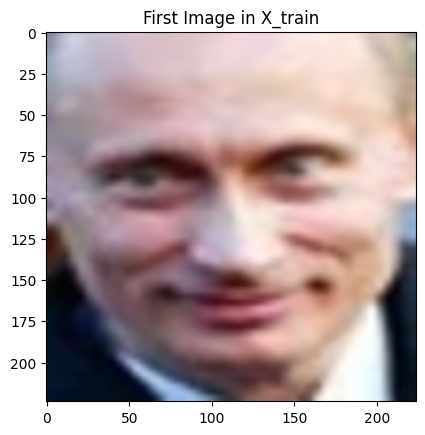

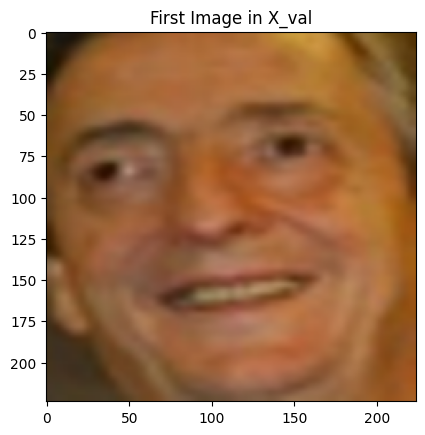

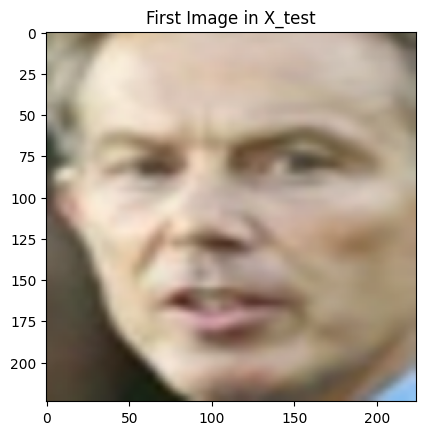

Epoch 1/12
605/605 [==============================] - 319s 519ms/step - loss: 13.4237 - accuracy: 0.3996 - val_loss: 3.1367 - val_accuracy: 0.4198 - lr: 0.0010
Epoch 2/12
605/605 [==============================] - 310s 512ms/step - loss: 2.9392 - accuracy: 0.4930 - val_loss: 2.7683 - val_accuracy: 0.5322 - lr: 0.0010
Epoch 3/12
605/605 [==============================] - 312s 516ms/step - loss: 2.6001 - accuracy: 0.5621 - val_loss: 2.5444 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 4/12
605/605 [==============================] - 312s 516ms/step - loss: 2.2886 - accuracy: 0.6458 - val_loss: 2.1760 - val_accuracy: 0.6545 - lr: 0.0010
Epoch 5/12
605/605 [==============================] - 312s 516ms/step - loss: 1.9951 - accuracy: 0.7192 - val_loss: 1.8850 - val_accuracy: 0.7256 - lr: 0.0010
Epoch 6/12
605/605 [==============================] - 305s 503ms/step - loss: 1.6776 - accuracy: 0.7852 - val_loss: 1.7807 - val_accuracy: 0.7967 - lr: 9.0484e-04
Epoch 7/12
605/605 [=====================

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 5s 279ms/step


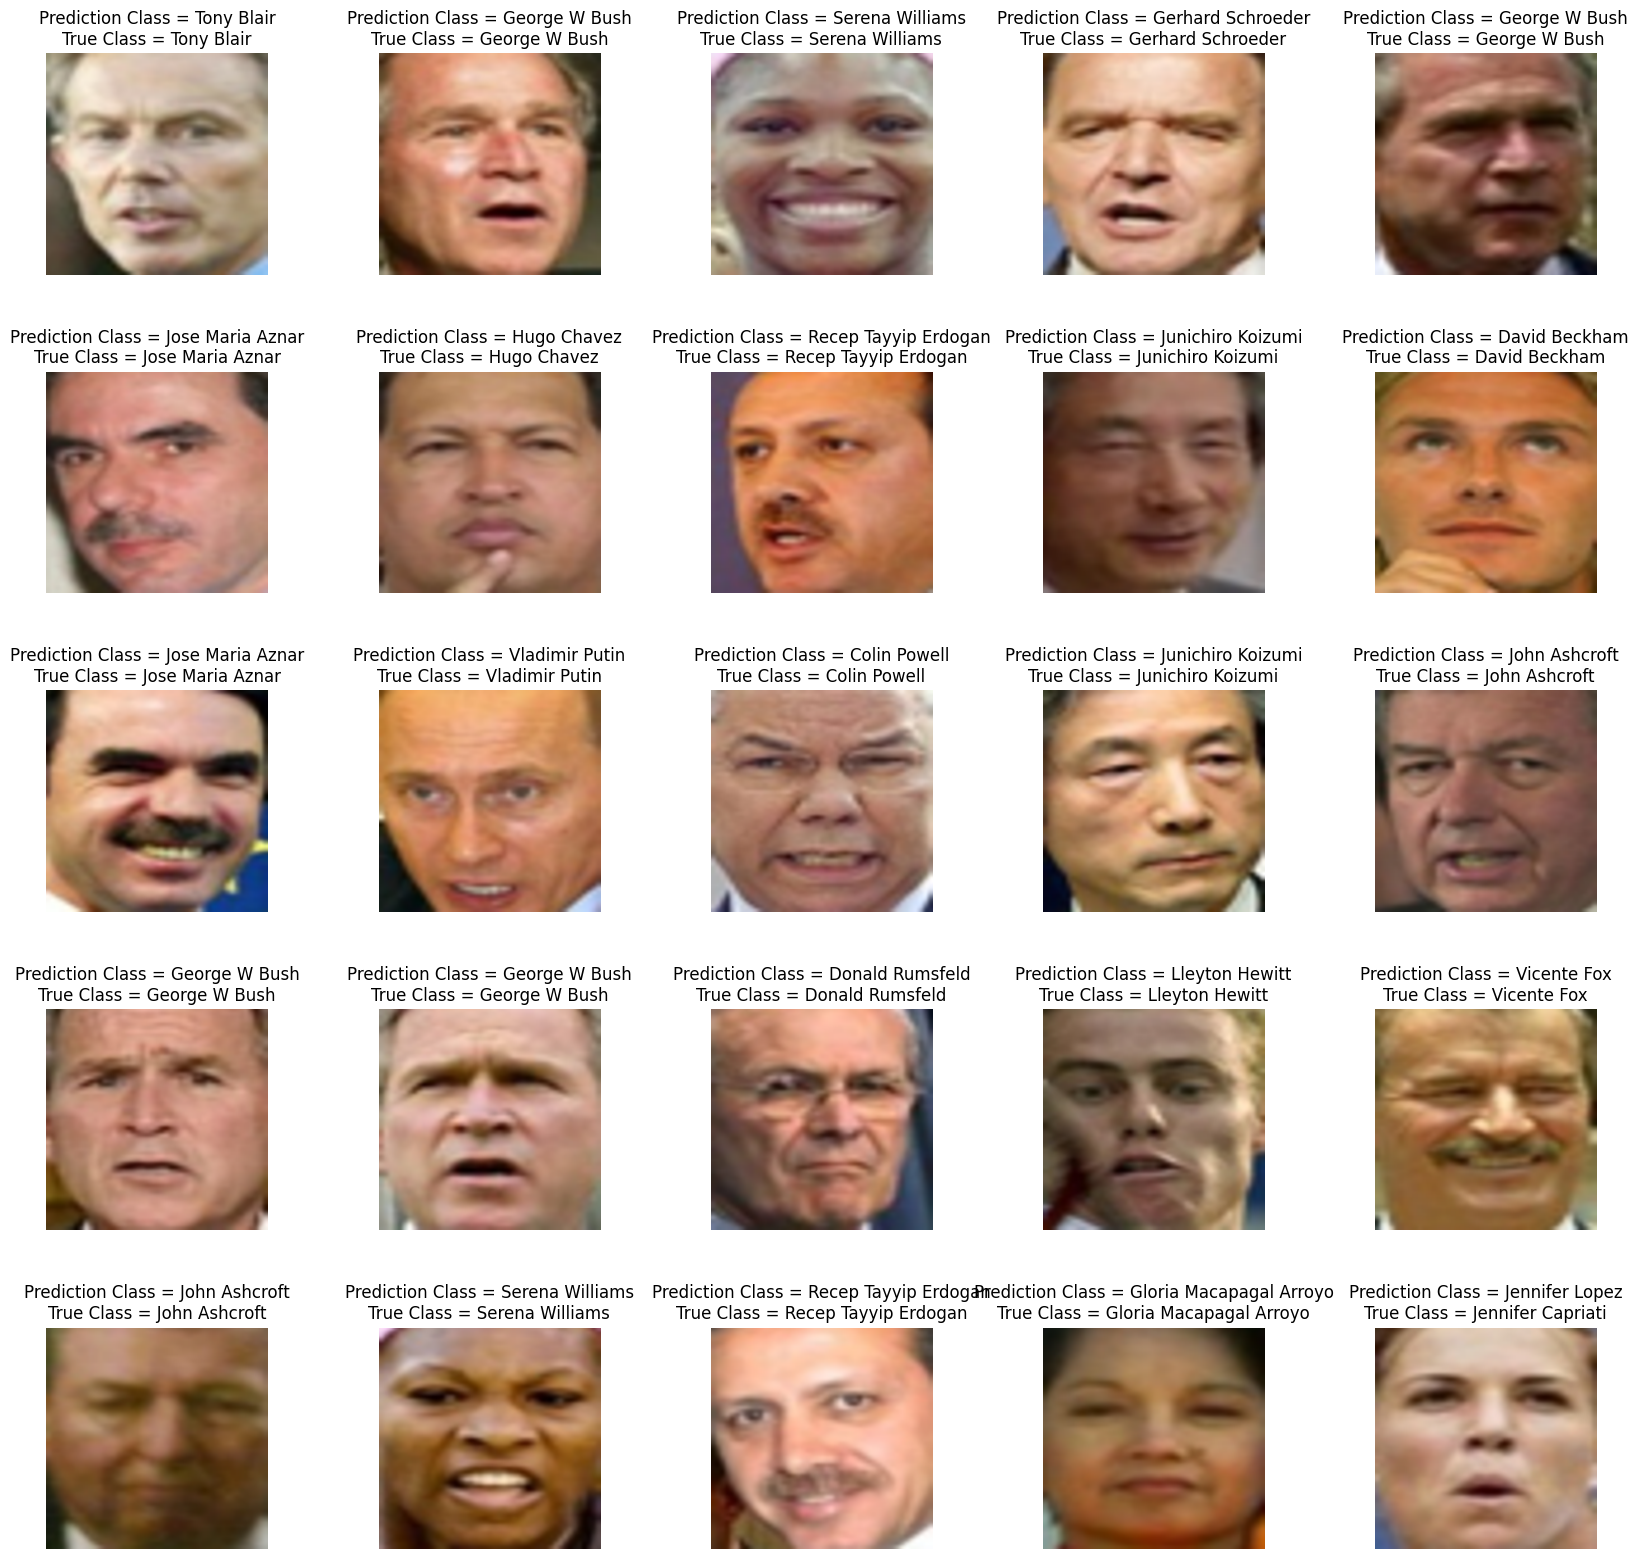

In [56]:
import time
import os
import json
#df, num_classes = load_dataset('../lfw_augmented_dataset.db')
#X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(df)

train_database_path = '/Users/sadhanaanandan/monorepo/Model/lfw_augmented_dataset.db'
val_test_database_path = '/Users/sadhanaanandan/monorepo/Model/lfw_dataset.db'
train_table = 'faces'
val_table = 'faces_val'
test_table = 'faces_test'

X_train, X_val, X_test, y_train, y_val, y_test, num_classes, df = load_dataset(train_database_path, val_test_database_path, train_table, val_table, test_table)
#X_train, X_val, X_test, y_train, y_val, y_test = preprocess2(X_train, X_val, X_test, y_train, y_val, y_test, num_classes)

#Preprocessing for model 1
#y_train, y_val, y_test = preprocess1(y_train, y_val, y_test, num_classes)

#Preprocessing for model 2
X_train, X_val, X_test, y_train, y_val, y_test = preprocess3(X_train, X_val, X_test, y_train, y_val, y_test, num_classes)

input_shape = (62, 47, 3)

# Train the model
#cnn_model, history = train_cnn_model(input_shape, num_classes, X_train, y_train, X_test, y_test)
cnn_model, history = train_model_v3(num_classes, X_train, y_train, X_val, y_val)
#Evaluate the model
#accuracy1, precision, recall, f1 = evaluate_model(cnn_model, X_test, y_test)
#evaluation_metrics = {
#    "accuracy": accuracy1,
#    "precision": precision,
#    "recall": recall,
#    "f1_score": f1
#}

evaluation_results = {}
evaluation_results['accuracy'], evaluation_results['precision'], evaluation_results['recall'], evaluation_results['f1'] = evaluate_model(cnn_model, X_test, y_test)

# Print or use the results as needed
print("Accuracy:", evaluation_results['accuracy'])
print("Precision:", evaluation_results['precision'])
print("Recall:", evaluation_results['recall'])
print("F1:", evaluation_results['f1'])

# Save the trained model
save_path = "./model_registry/"
timestamp = time.strftime("%Y%m%d%H%M%S")
cnn_model.save(f'{save_path}model_version_{timestamp}.h5')
# when the model is initally trained the way we load the model gives 0.0 for all evaluation metrics
# therefore, we save the evaluation metrics in a json file
metrics_file_path = os.path.join(save_path, 'evaluation_metrics.json')
with open(metrics_file_path, 'w') as metrics_file:
    json.dump(evaluation_results, metrics_file)

#visualize the model on test set
visualize_predictions(df, cnn_model, X_test, y_test)


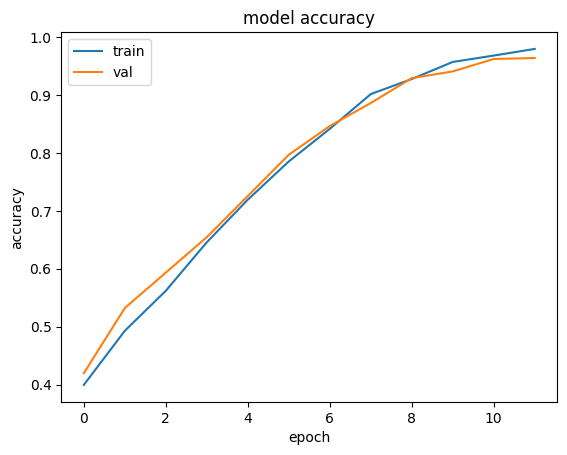

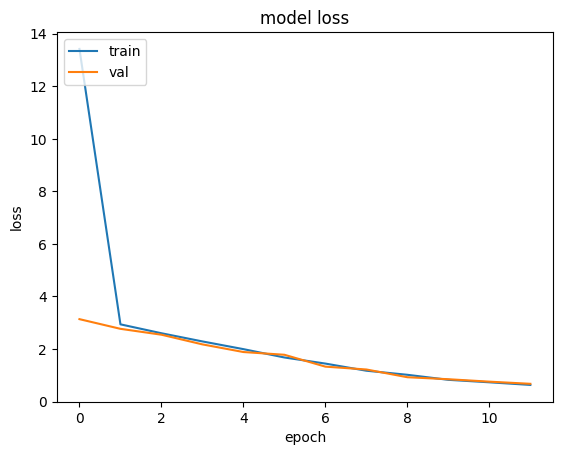

In [57]:
def plot_accuracy_and_loss(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_accuracy_and_loss(history)

In [58]:
"""
from numpy import expand_dims
from keras.models import Model

def visualize_feature_maps(model, image):
    
    #Get indices of convolutional layers
    conv_layer_indices = [i for i, layer in enumerate(model.layers) if isinstance(layer, Conv2D)]

    #Create a list to store convolutional layers
    conv_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]

    #Create a new model containing only the convolutional layers
    model2 = Model(inputs=model.inputs, outputs=[layer.output for layer in conv_layers])

    #Expand the dimensions of the input to match the model's expected input shape
    image = expand_dims(image, axis=0)

    #Get the feature maps
    feature_maps = model2.predict(image)
    summed_feature_maps = [fmap_list.sum(axis=-1) for fmap_list in feature_maps]

    #Plot the feature maps
    fig = plt.figure(figsize=(15, 15))
    layer_index = 0

    for summed_fmap in summed_feature_maps:
        ax = plt.subplot(len(conv_layers), 1, layer_index + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(summed_fmap[0, :, :], cmap='gray')

        layer_index += 1

    plt.show()
    
visualize_feature_maps(cnn_model, X_train[0])
"""

"\nfrom numpy import expand_dims\nfrom keras.models import Model\n\ndef visualize_feature_maps(model, image):\n    \n    #Get indices of convolutional layers\n    conv_layer_indices = [i for i, layer in enumerate(model.layers) if isinstance(layer, Conv2D)]\n\n    #Create a list to store convolutional layers\n    conv_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]\n\n    #Create a new model containing only the convolutional layers\n    model2 = Model(inputs=model.inputs, outputs=[layer.output for layer in conv_layers])\n\n    #Expand the dimensions of the input to match the model's expected input shape\n    image = expand_dims(image, axis=0)\n\n    #Get the feature maps\n    feature_maps = model2.predict(image)\n    summed_feature_maps = [fmap_list.sum(axis=-1) for fmap_list in feature_maps]\n\n    #Plot the feature maps\n    fig = plt.figure(figsize=(15, 15))\n    layer_index = 0\n\n    for summed_fmap in summed_feature_maps:\n        ax = plt.subplot(len(conv_